<a href="https://colab.research.google.com/github/TanushGoel/Machine-Learning-Playground/blob/master/Malaria_Detection_with_Automated_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IN PROGRESS

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os.path import isfile
import PIL
from PIL import Image, ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 
np.random.seed(42)

In [0]:
!pip3 -q install tensorflow==1.14.0

In [0]:
!pip3 -q install keras

In [0]:
import tensorflow as tf
import keras
from keras.utils import np_utils

In [0]:
tf.__version__

'1.14.0'

In [0]:
!pip3 -q install talos

In [0]:
import talos as ta

In [0]:
ta.__version__

'0.6.3'

In [0]:
!pip3 -q install kaggle

In [0]:
# upload kaggle token 'kaggle.json'
from google.colab import files
files.upload()

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d 'iarunava/cell-images-for-detecting-malaria'

 98% 660M/675M [00:06<00:00, 123MB/s]
100% 675M/675M [00:07<00:00, 97.8MB/s]


In [0]:
# upload zipped file before this step
!unzip -o -q 'cell-images-for-detecting-malaria.zip'

# -f  freshen existing files, create none
# -n  never overwrite existing files         
# -q  quiet mode (-qq => quieter)
# -o  overwrite files WITHOUT prompting    

In [0]:
print(os.listdir("cell_images"))

['Uninfected', 'Parasitized', 'cell_images']


In [0]:
infected = os.listdir('cell_images/Parasitized/') 
uninfected = os.listdir('cell_images/Uninfected/')

In [0]:
# Create dataframes

inputs = np.empty(shape=(27558, 50, 50, 3), dtype='float32')
targets = np.empty(shape=(27558), dtype='uint8')

x=0
for i in infected:
  try:
    img = Image.open("cell_images/Parasitized/"+i).resize((50, 50))
    inputs[x] = np.array(img)/255
    targets[x] = 1
    x+=1
  except:
    print(i, 'could not be opened')
        
for u in uninfected:
  try:
    img = Image.open("cell_images/Parasitized/"+i).resize((50, 50))
    inputs[x] = np.array(img)/255
    targets[x] = 0
    x+=1
  except:
    print(u, 'could not be opened')

Thumbs.db could not be opened
C37BP2_thinF_IMG_20150620_131423a_cell_51.png could not be opened


In [0]:
inputs.shape

(27558, 50, 50, 3)

In [0]:
targets.shape

(27558,)

In [0]:
# Train, Valid, Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=13579)
del inputs
del targets

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=24680)

print('Train:', X_train.shape[0])
print('Valid:', X_valid.shape[0])
print('Test:', X_test.shape[0])

Train: 19841
Valid: 2205
Test: 5512


Text(0.5, 0.98, 'Images')

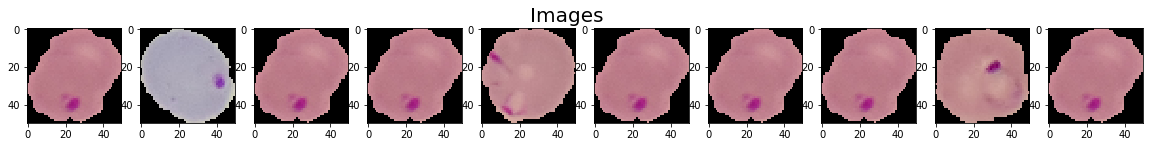

In [0]:
# Visualize Images

fig = plt.figure(figsize=(20,2))
for i in range(0, 10):
  ax = fig.add_subplot(1, 10, i+1)
  ax.imshow(X_train[i])
fig.suptitle('Images', fontsize=20)

In [0]:
# Data Augmentation

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (90 degrees)
        zoom_range=0.1, # randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
        height_shift_range=0.1, # randomly shift images vertically (10% of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images)

datagen.fit(X_train)

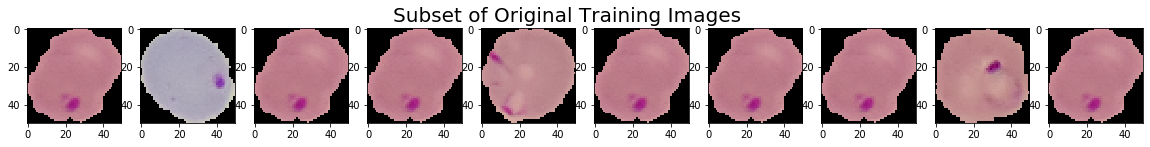

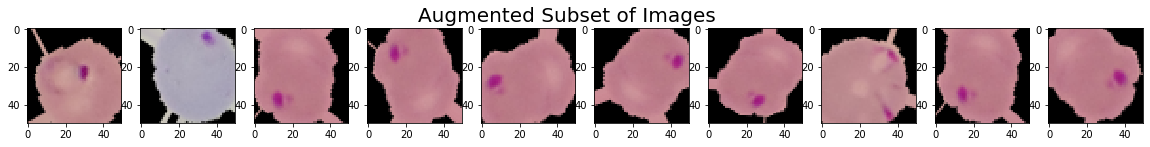

In [0]:
# Take subset of training data
X_train_subset = X_train[:10]

# Visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(X_train_subset)):
  ax = fig.add_subplot(1, 10, i+1)
  ax.imshow(X_train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)

# Visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen.flow(X_train_subset, batch_size=10):
    for i in range(0, 10):
        ax = fig.add_subplot(1, 10, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Subset of Images', fontsize=20)
    plt.show()
    break
    
del X_train_subset

In [0]:
# Reshape Images

X_train = X_train.reshape(X_train.shape[0], *(50, 50, 3))
X_valid = X_valid.reshape(X_valid.shape[0], *(50, 50, 3))
X_test = X_test.reshape(X_test.shape[0], *(50, 50, 3))

In [0]:
# Encode Categorical Integer Labels to One-Hot Scheme
from tensorflow.python.keras.utils import np_utils

# print first 10 integer-valued training labels
print('integer-valued labels:')
print(y_train[:5])

# one-hot encode the labels
y_train = np_utils.to_categorical(y_train, 2)
y_valid = np_utils.to_categorical(y_valid, 2)
y_test = np_utils.to_categorical(y_test, 2)

# print first ten one-hot training labels
print('one-hot labels:')
print(y_train[:5])

integer-valued labels:
[0 1 0 0 1]
one-hot labels:
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [0]:
# Build Model

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation, GlobalAveragePooling2D

def malaria_model(x_train, y_train, x_val, y_val, params):

    model = Sequential()
    
    filters=params['filters']
    
    for i in range(0, params['num_conv']):
        model.add(Conv2D(filters=filters, kernel_size=params['kernel_size'], padding='same', activation=params['activation']))
        model.add(MaxPooling2D(pool_size=params['pool_size']))
        model.add(Dropout(params['dropout_conv']))
        filters*=2
  
    model.add(Flatten())
  
    for i in range(0, params['num_dense']):
        model.add(Dense(units=params['units_dense'], activation=params['activation']))
        model.add(Dropout(params['dropout_dense']))

    model.add(Dense(2, activation='softmax'))
    
    
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'],
                  metrics=['accuracy'])
    
    
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=params['batch_size']), 
                                  validation_data=(x_val, y_val),
                                  shuffle=True,
                                  epochs=params['epochs'],
                                  verbose=1)
    
    return history, model

In [0]:
# then we can go ahead and set the parameter space
params = {'num_conv':[3], 
     'filters':[16,32],
     'kernel_size':[3],
     'pool_size':[2],
     'dropout_conv': [0.25],
     'num_dense':[1,2],
     'units_dense':[256,512],
     'dropout_dense': [0.25],
     'losses': ['binary_crossentropy'],
     'optimizer': ['adam'],
     'activation':['relu'], 
     'batch_size': [16],
     'epochs': [3]}

In [0]:
h = ta.Scan(X_train, y_train, params=params,
        model=malaria_model, 
        experiment_name='malaria')

In [0]:
# accessing the results data frame
h.data.head()

# accessing epoch entropy values for each round
h.peak_epochs_df

# access the summary details
h.details

In [0]:
# accessing the saved models
h.saved_models

# accessing the saved weights for models
h.saved_weights

In [0]:
# use Scan object as input
r = ta.Reporting(h)

# use filename as input
r = ta.Reporting('malaria_saved_1.csv')

In [0]:
# get the number of rounds in the Scan
r.rounds()

# get the highest result ('val_acc' by default)
r.high()

# get the highest result for any metric
r.high('acc')

# get the round with the best result
r.rounds2high()

# get the best paramaters
r.best_params()

# get correlation for hyperparameters against a metric
r.correlate('val_loss')


In [0]:
# a regression plot for two dimensions 
r.plot_regs()

# line plot
r.plot_line()

# up to two dimensional kernel density estimator
r.plot_kde('val_acc')

# a simple histogram
r.plot_hist(bins=50)

# heatmap correlation
r.plot_corr()

# a four dimensional bar grid
r.plot_bars('batch_size', 'val_acc', 'first_neuron', 'lr')

In [0]:
ta.Deploy(h, 'malaria_saved')

In [0]:
malaria = ta.Restore('malaria_saved.zip')

In [0]:
# get the meta-data for the experiment
malaria.details

In [0]:
# get the hyperparameter space boundary
malaria.params

In [0]:
# the results dataframe
malaria.results

In [0]:
# Test Predictions

y_pred = np.argmax(malaria.model.predict(X_test), axis=1)

In [0]:
# Evaluate
score = malaria.model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

print(f'Test Accuracy: {accuracy:1.2f}%')

In [0]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g', cbar=False, cmap="viridis")
plt.imshow(conf_matrix, interpolation='nearest', cmap='viridis')
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [0]:
from sklearn.metrics import classification_report

report = classification_report(np.argmax(y_test, axis=1), y_pred)
print(report)